In [1]:
import numpy as np
import random
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv
import os
from alpaca_trade_api.rest import REST, TimeFrame
import hvplot.pandas
from scipy.interpolate import interp1d

import warnings
warnings.filterwarnings('ignore')

In [9]:
def fetch_stock_data(api_key, secret_key, start_date, end_date, tickers, timeframe = '1Day'):
    api = REST(api_key, secret_key, base_url = 'https://paper-api.alpaca.markets')
    start_date_iso = pd.Timestamp(start_date, tz = 'America/New_York').isoformat()
    end_date_iso = pd.Timestamp(end_date, tz = 'America/New_York').isoformat()
    
    df_ticker = api.get_bars(tickers, TimeFrame.Day, start = start_date_iso, end = end_date_iso).df
    dfs = {}
    for ticker in tickers:
        ticker_df = df_ticker.loc[df_ticker.symbol == ticker].drop('symbol', axis = 1)
        ticker_df = ticker_df['close']
        dfs[ticker] = ticker_df
    new_df = pd.concat(dfs.values(), axis = 1, keys = tickers)
    return new_df

In [3]:
load_dotenv()

True

In [5]:
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

In [12]:
stock_list = ['AAPL', 'KO', 'SBUX', 'WMT']
df = fetch_stock_data(alpaca_api_key, alpaca_secret_key, '2017-01-01', '2020-01-01', stock_list)

In [13]:
df

,AAPL,KO,SBUX,WMT
timestamp,,,,
2017-01-03 05:00:00+00:00,116.15,41.80,55.350,68.66
2017-01-04 05:00:00+00:00,116.02,41.65,55.990,69.06
2017-01-05 05:00:00+00:00,116.61,41.75,56.460,69.21
2017-01-06 05:00:00+00:00,117.91,41.74,57.130,68.26
2017-01-09 05:00:00+00:00,118.99,41.32,58.200,68.71
...,...,...,...,...
2019-12-24 05:00:00+00:00,284.27,54.71,88.520,119.51
2019-12-26 05:00:00+00:00,289.91,55.02,88.075,119.52
2019-12-27 05:00:00+00:00,289.80,55.35,88.130,119.59


In [15]:
def portfolio_return_pandas(stock_df, weight_list):
    daily_return = stock_df.pct_change().dropna()
    portfolio_mean = daily_return.dot(weight_list).mean()
    return portfolio_mean



def portfolio_risk_pandas(stock_df, weight_list):
    daily_return = stock_df.pct_change()
    cov_matrix = daily_return.cov()

    weight_mat = np.matrix(weight_list)
    cov_mat = np.matrix(cov_matrix)
    port_risk = np.sqrt(np.dot(np.dot(weight_mat, cov_mat), weight_mat.T)).item()
    return port_risk

In [16]:
def mc_sim(df, weight_list, length, nsims, investment_amount = 1, kind = 'line'):
    port_return = portfolio_return_pandas(df, weight_list)
    port_risk = portfolio_risk_pandas(df, weight_list)
    portfolio_sims = np.full(shape = (length, nsims), fill_value = 0.0)
    for i in range(0, nsims):
        simulation = np.full(shape = (length, 1), fill_value = 1)
        rand = np.random.normal(port_return, port_risk, length).T.reshape((length,1))
        simulations = np.cumprod(simulation + rand) * investment_amount
        portfolio_sims[:,i] = simulations
    sim_df = pd.DataFrame(portfolio_sims)
    if kind == 'line':
        plt.plot(portfolio_sims)
        plt.title('Monte Carlo Simulation of portfolio')
        plt.xlabel('Days')
        plt.ylabel('Portfolio value')
    elif kind == 'kde':
        ax = sim_df.iloc[-1,:].hvplot.kde(alpha = 0.1, title = 'KDE plot of the end result of Monte Carlo Simulation', yformatter = '%.5f')
        display(ax)

    return sim_df

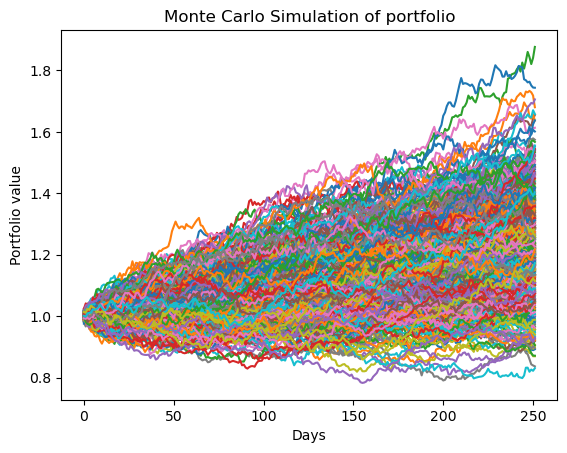

In [20]:
sim_df = mc_sim(df, [0.25, 0.25, 0.25, 0.25], 252, 500)